In [2]:
library(tidyverse)
library(alakazam)
library(shazam)
library(ggplot2)
library(magrittr)
library(ggpubr)
library(stats)
library(stringr)
library(ggrepel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.


Attaching package: ‘magrittr’


T

# Read in data

In [3]:
meta <- read.csv('../all_sample_meta.csv', header = T)
files <- dir('../data/')

In [4]:
files 
length(files)

[1] "GW"   "GZR"  "HXR"  "HXR2" "HXX"  "LGY"  "LL"   "LL2"  "MXY"  "QJY" 
[11] "SQ"   "WYF"  "WYF2" "WYY"  "XH"   "XYY"  "XYY2" "ZH"   "ZMY1" "ZPP" 
[21] "ZPP2" "ZS"

[1] 22

In [5]:
tmp <- read.csv('../data/GW/10X_clone-pass_germ-pass.tsv', header = T, sep = '\t')
head(tmp,2)
dim(tmp)

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,umi_count,v_call_10x,d_call_10x,j_call_10x,junction_10x,junction_10x_aa,germline_alignment_d_mask,germline_v_call,germline_d_call,germline_j_call
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TGGCGCAGTCAATGTC-1_contig_1,CTCACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGATGGGAGTAGCACAAGCTACGCGGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV3-74*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNTATTACTATGATAGTAGTGGTTATTACTACNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,⋯,49,IGHV3-74,IGHD3-22,IGHJ4,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,CARAQSYYYDSSGYYYEGGFDYW,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,IGHV3-74*01,IGHD3-22*01,IGHJ4*02
2,CTGCTGTGTTGGTTTG-1_contig_2,GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGCACTGAACACAGAGGACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTCGTTGCTCTTTTAAGAGGTGTCCAGTGTCAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGATGGAAGTAATAAATACTATGCAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,"IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03","IGHD1-14*01,IGHD3-10*01,IGHD3-10*02","IGHJ4*02,IGHJ5*02",CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAGAGANNCGGAANNNTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCGAAAGATTCGGAAACATGG,⋯,19,IGHV3-30,,IGHJ4,TG

[1] 1067   62

In [6]:
# different Ig class ratio 
HC_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
SLE_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
for (file in files){
    name = str_split(file,'_')[[1]][1]
    # assign(name, read.csv(paste0('./vdj/VDJtools/bcr_data/',file),header = T))
    tmp <-  read.csv(paste0('../data/',file,'/10X_clone-pass_germ-pass.tsv'),header = T,sep = '\t')
    tmp %<>% mutate(sample = name)
    if(meta$group[which(meta$name == name)] == 'HC' ){
        HC_df <- rbind(HC_df,tmp)
    }else if(meta$group[which(meta$name == name)] == 'SLE'){
        SLE_df <- rbind(SLE_df, tmp)
    }
}


In [6]:
dim(HC_df)
dim(SLE_df)

[1] 4913   63

[1] 32888    63

In [7]:
SLE_df$disease <- 'SLE'
HC_df$disease <- 'HC'
all_df <-rbind(SLE_df, HC_df)

# remove the cell without RNA

In [31]:
bcell_rna_meta <- read.csv('./seurat_bcell_filter_meta.csv')
plasma_rna_meta <- read.csv('./seurat_plasma_filter_meta.csv')
bcell_rna_meta <- bcell_rna_meta[,c('X','orig.ident','nCount_RNA','nFeature_RNA','group','treatment','pair','percent_mito','percent_ribo','S.Score','G2M.Score','Phase','old.ident','RNA_snn_res.0.8','RNA_snn_res.1','seurat_clusters','main_type','subtype')]
plasma_rna_meta <- plasma_rna_meta[,c('X','orig.ident','nCount_RNA','nFeature_RNA','group','treatment','pair','percent_mito','percent_ribo','S.Score','G2M.Score','Phase','old.ident','RNA_snn_res.0.8','RNA_snn_res.1','seurat_clusters','main_type','subtype')]
rna_meta <- rbind(bcell_rna_meta, plasma_rna_meta)

In [32]:
rna_meta %>% head()

,X,orig.ident,nCount_RNA,nFeature_RNA,group,treatment,pair,percent_mito,percent_ribo,S.Score,G2M.Score,Phase,old.ident,RNA_snn_res.0.8,RNA_snn_res.1,seurat_clusters,main_type,subtype
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,GW_SLE_AAACCTGCACCGCTAG-1,GW,3424,1471,SLE,untreated,unpaired,1.2266355,25.08762,0.019518217,-0.01128194,S,4,6,7,6,Bcell,B.mem.IGHM+
2,GW_SLE_AAACCTGCACTAAGTC-1,GW,3141,1494,SLE,untreated,unpaired,0.8914358,22.98631,-0.053058536,0.12593886,G2M,1,2,3,2,Bcell,B.transition
3,GW_SLE_AAACCTGGTCTCTTAT-1,GW,5943,2090,SLE,untreated,unpaired,1.2956419,31.95356,-0.016969722,0.00838082,G2M,4,6,7,6,Bcell,B.mem.IGHM+
4,GW_SLE_AAACGGGCACAGATTC-1,GW,4084,1440,SLE,untreated,unpaired,1.3956905,35.13712,0.022346844,-0.03217804,S,1,1,3,1,Bcell,B.naive
5,GW_SLE_AAACGGGGTTTGTTTC-1,GW,4269,1767,SLE,untreated,unpaired,1.5928789,28.36730,-0.006082996,-0.01183525,G1,3,8,4,8,Bcell,B.mem
6,GW_SLE_AAAGATGCAGTATAAG-1,GW,5798,2110,SLE,untreated,unpaired,2.0869265,27.99241,0.065865883,0.04639433,S,2,0,3,0,Bcell,B.naive


In [33]:
all_df %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"

In [34]:
all_df$barcode_match <- paste0(all_df$sample,'_',all_df$disease,'_',str_split_fixed(all_df$sequence_id, '_',n = 3)[,1])

In [35]:
all_df$barcode_match %>% length()
rna_meta$X %>% length()

[1] 37801

[1] 26037

In [36]:
intersect(all_df$barcode_match, rna_meta$X ) %>% length()

[1] 24027

In [37]:
filter_all_df <- all_df[which(all_df$barcode_match %in% rna_meta$X),]
filter_all_df %>% dim()

[1] 24027    65

In [38]:
filter_all_df <- left_join(filter_all_df, rna_meta, by = c('barcode_match' = 'X'))

In [39]:
filter_all_df %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"                  
[65] "barcode_match"             "orig.ident"               
[67] "nCount_RNA"                "nFeature_RNA"             
[69] "group"                     "treatment"                
[71] "pair"                      "percent_mito"             
[73] "percent_ribo"              "S.Score"                  
[75] "G2M.Score"                 "Phase"                    
[77] "old.ident"                 "RNA_snn_res.0.8"          
[79] "RNA_snn_res.1"             "seurat_clusters"          
[81] "main_type"                 "subtype"

In [41]:
v_j_combine <- filter_all_df %>% select(c('v_call','j_call','disease','subtype','orig.ident')) %>% mutate(combine = (grepl('IGHV3-23',.[,1]) + grepl('IGHJ4',.[,2])) ) %>% filter(combine == 2)
v_j_combine[1:5,]

,v_call,j_call,disease,subtype,orig.ident,combine
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.transition,GW,2
2,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.naive,GW,2
3,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.mem,GW,2
4,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.IFN-response,GW,2
5,"IGHV3-23*01,IGHV3-23D*01",IGHJ4*02,SLE,B.naive,GW,2


In [42]:
dim(v_j_combine)

[1] 1378    6

# SHM

In [54]:
# db_obs_hc <- observedMutations(HC_df, sequenceColumn="sequence_alignment",
#                             germlineColumn="germline_alignment_d_mask",
#                             regionDefinition=NULL,
#                             frequency=TRUE, 
#                             nproc=24)
# db_obs_sle <- observedMutations(SLE_df, sequenceColumn="sequence_alignment",
#                             germlineColumn="germline_alignment_d_mask",
#                             regionDefinition=NULL,
#                             frequency=TRUE, 
#                             nproc=32)
# db_obs_hc$disease <- 'HC'
# db_obs_sle$disease <- 'SLE'
# db_obs_all <- rbind(db_obs_hc,db_obs_sle)
# db_obs_all %<>% filter(c_call != ',')

In [74]:
db_obs_all <- observedMutations(filter_all_df, sequenceColumn="sequence_alignment",
                            germlineColumn="germline_alignment_d_mask",
                            regionDefinition=NULL,
                            frequency=TRUE, 
                            nproc=32)
db_obs_all %<>% filter(c_call != '')

In [140]:
colnames(filter_all_df)

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"                  
[65] "barcode_match"

# C gene usage

In [148]:
filter_all_df_sle <- filter_all_df[which(filter_all_df$disease == 'SLE'),]
filter_all_df_hc <- filter_all_df[which(filter_all_df$disease == 'HC'),]
dim(filter_all_df_sle)
dim(filter_all_df_hc)

[1] 20200    82

[1] 3827   82

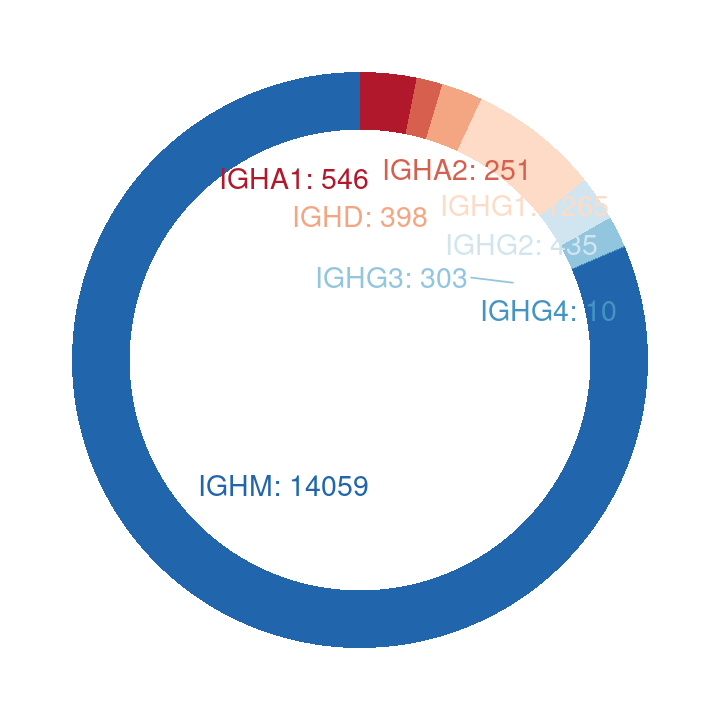

In [167]:
a

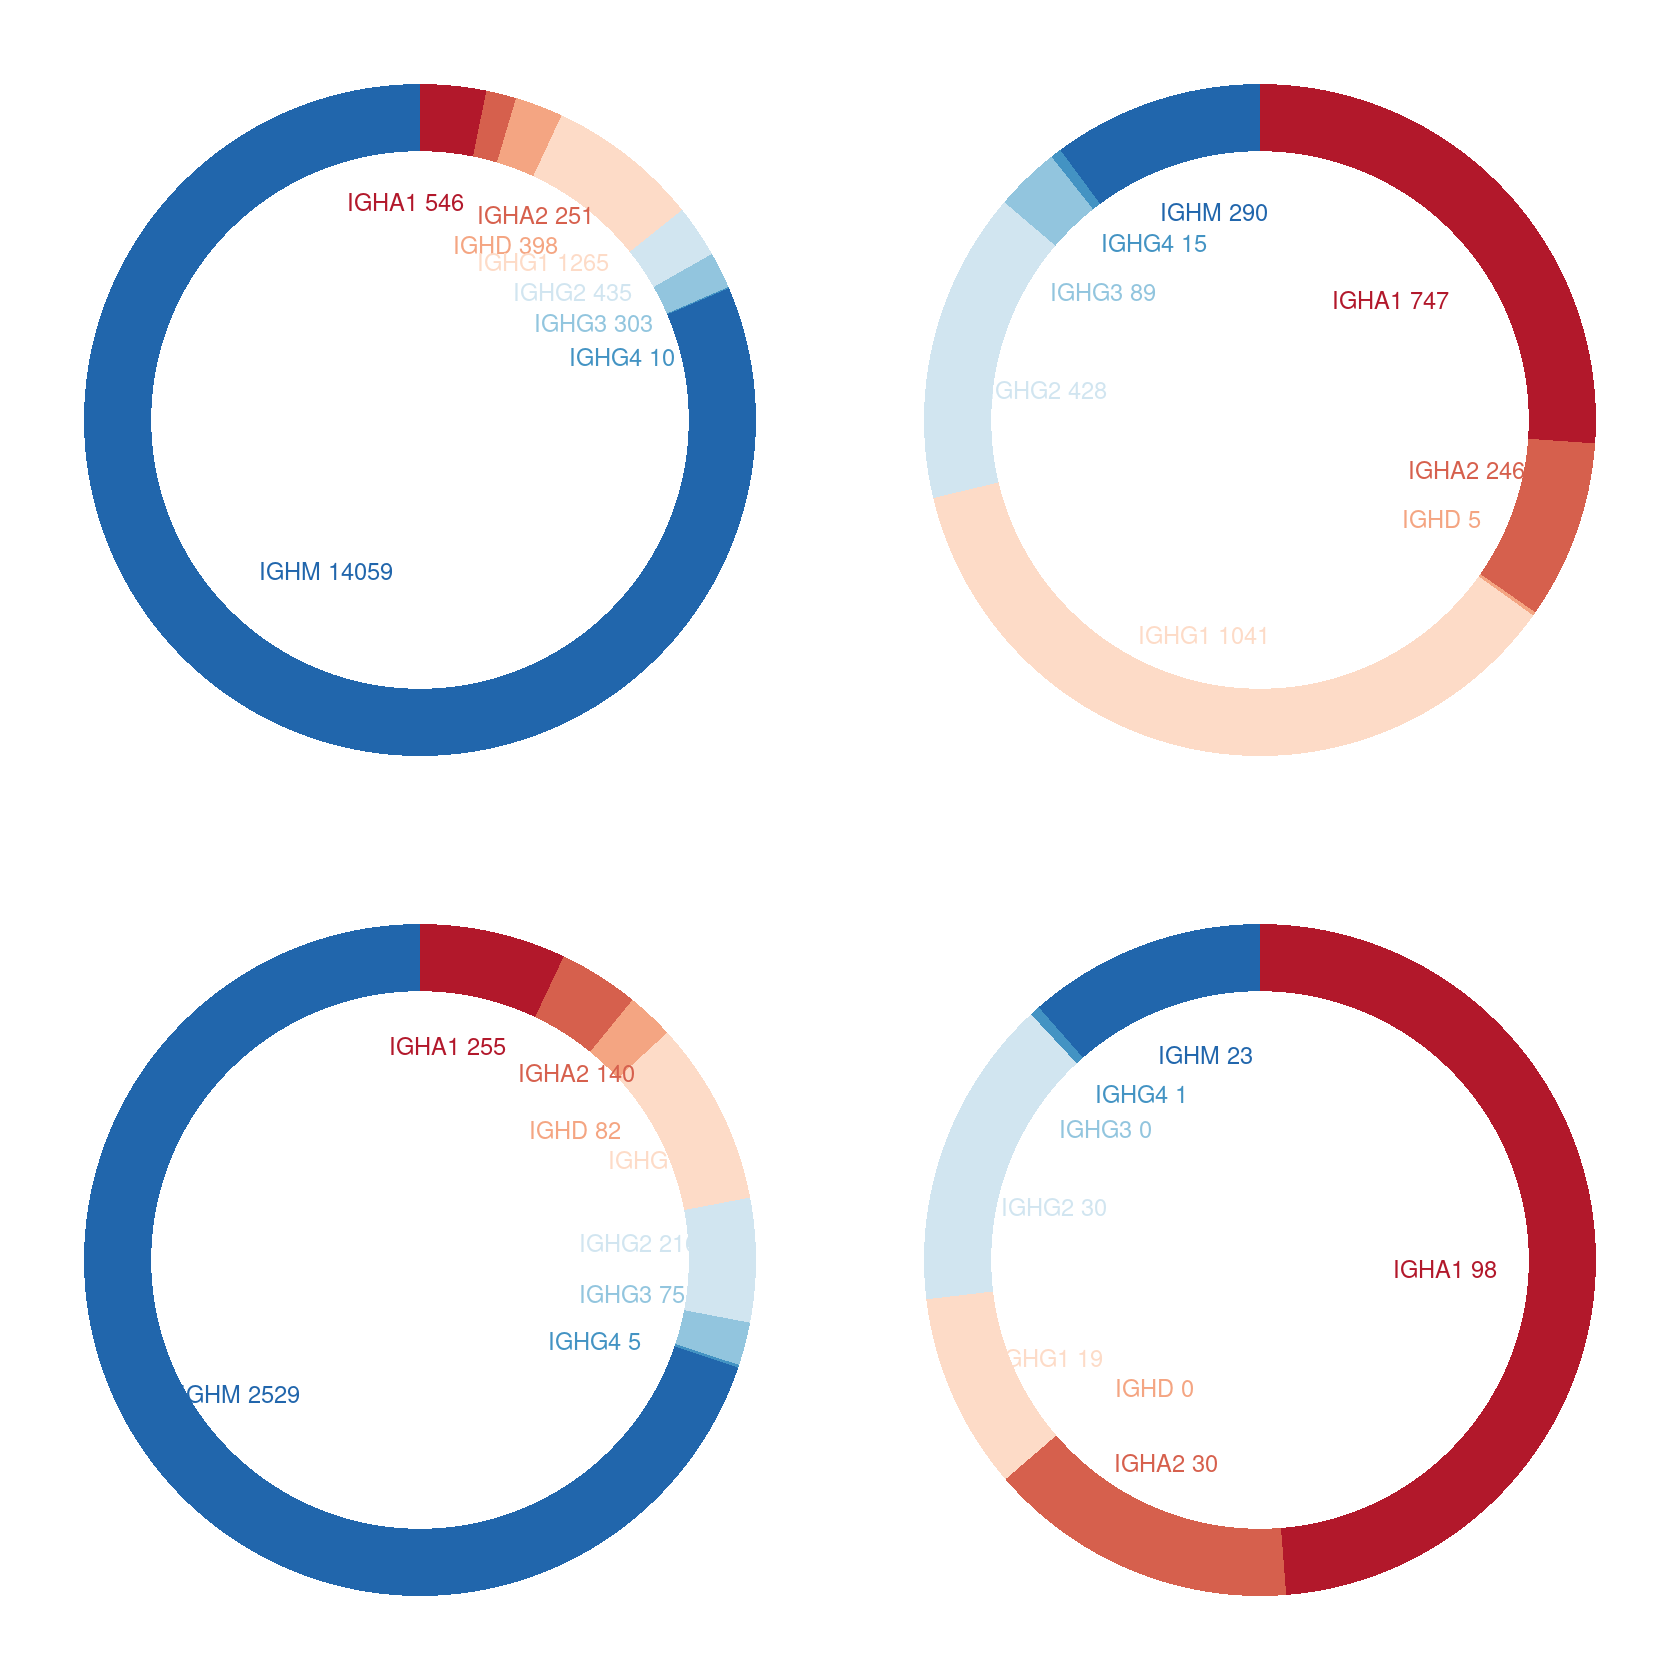

In [180]:
# sle
sle_c_pie <- table(filter_all_df_sle$c_call , filter_all_df_sle$main_type) %>% data.frame()
sle_c_pie_bcell <- sle_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(sle_c_pie_bcell) <- c('C gene','main_type','count')
a <- pie_plot(sle_c_pie_bcell,'count','C gene')

sle_c_pie_plasma <- sle_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(sle_c_pie_plasma) <- c('C gene','main_type','count')
b <- pie_plot(sle_c_pie_plasma,'count','C gene')


# hc
hc_c_pie <- table(filter_all_df_hc$c_call , filter_all_df_hc$main_type) %>% data.frame()
hc_c_pie_bcell <- hc_c_pie %>% filter(Var2 == 'Bcell') %>% filter(Var1 != '')
colnames(hc_c_pie_bcell) <- c('C gene','main_type','count')
c <- pie_plot(hc_c_pie_bcell,'count','C gene')

hc_c_pie_plasma <- hc_c_pie %>% filter(Var2 == 'Plasma') %>% filter(Var1 != '')
colnames(hc_c_pie_plasma) <- c('C gene','main_type','count')
d <- pie_plot(hc_c_pie_plasma,'count','C gene')

options(repr.plot.width=14, repr.plot.height=14)
ggarrange(a,b,c,d)

In [175]:
pie_plot <- function(data, count, group, title, out = False){
    # Compute percentages
    data$fraction <- data[[count]] / sum(data[[count]])

    # Compute the cumulative percentages (top of each rectangle)
    data$ymax <- cumsum(data$fraction)

    # Compute the bottom of each rectangle
    data$ymin <- c(0, head(data$ymax, n=-1))

    # Compute label position
    data$labelPosition <- (data$ymax + data$ymin) / 2

    # Compute a good label
    data$label <- paste0(data[[group]], " ", data[[count]])

    # Make the plot
    ggplot(data, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=get(group))) +
    geom_rect() +
    geom_text_repel( x=2, aes(y=labelPosition, label=label, color=get(group)), size=5) + # x here controls label position (inner / outer)
    scale_fill_brewer(palette='RdBu') +
    scale_color_brewer(palette='RdBu') +
    coord_polar(theta="y") +
    xlim(c(-1, 4)) +
    theme_void() +
    theme(legend.position = "none")
}

In [55]:
g1 <- ggplot(db_obs_hc, aes(x=c_call, y=mu_freq_seq_r, fill=c_call)) +
    theme_bw() + ggtitle("HC Total mutations") +
    xlab("Isotype") + ylab("Mutation frequency") +
    scale_fill_manual(name="Isotype", values=IG_COLORS) +
    geom_boxplot()
g2 <-ggplot(db_obs_sle, aes(x=c_call, y=mu_freq_seq_r, fill=c_call)) +
    theme_bw() + ggtitle("SLE Total mutations") +
    xlab("Isotype") + ylab("Mutation frequency") +
    scale_fill_manual(name="Isotype", values=IG_COLORS) +
    geom_boxplot()
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(g1, g2)

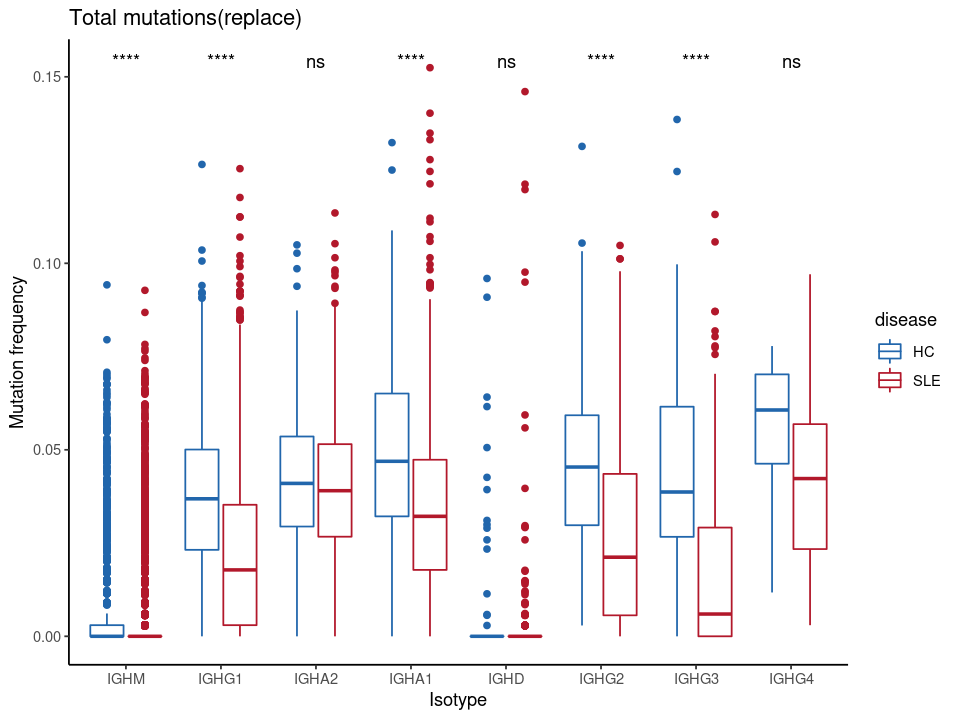

In [186]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_r", color = "disease",
 palette = c("#2166AC", "#B2182B")) + ggtitle("Total mutations(replace)") +
    xlab("Isotype") + ylab("Mutation frequency")  +
    theme_classic() + stat_compare_means(aes(group = disease), label = "p.signif")

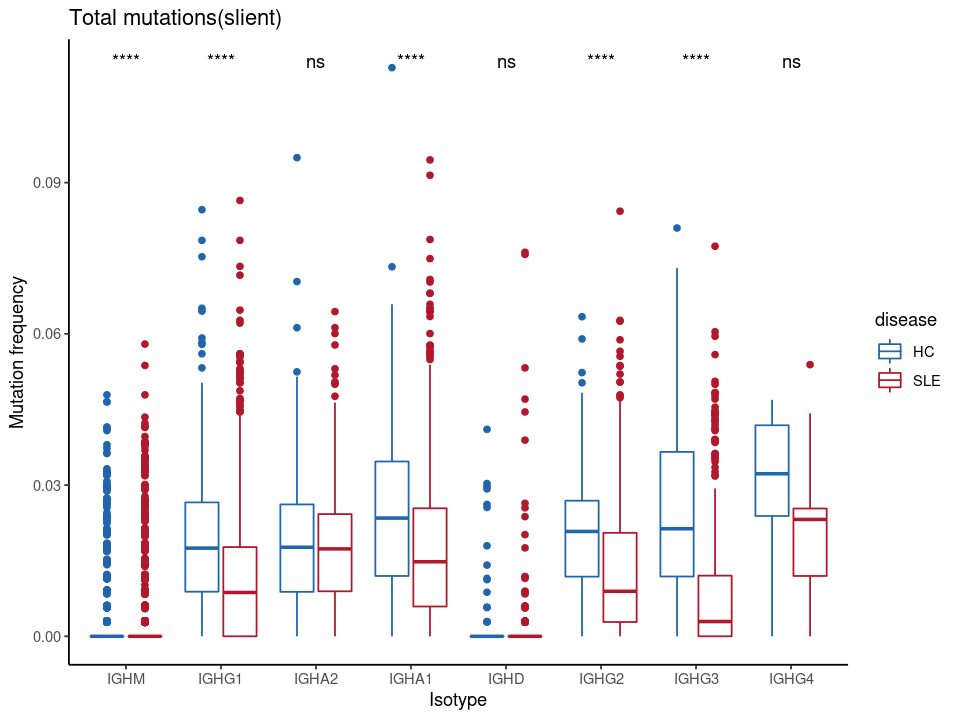

In [187]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_s", color = "disease",
 palette = c("#2166AC", "#B2182B")) + ggtitle("Total mutations(slient)") +
    xlab("Isotype") + ylab("Mutation frequency") +
    theme_classic() + stat_compare_means(aes(group = disease), label = "p.signif")

In [14]:
db_obs_all %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"                  
[65] "mu_freq_seq_r"             "mu_freq_seq_s"

In [16]:
write.csv(db_obs_all,'/rd2/user/xiacr/sle/scripts/immcantaion/bcell_immacantation_SHM.csv')

# SHM target model

In [77]:
# Create substitution model using silent mutations
sub_model <- createSubstitutionMatrix(filter_all_df, model="s", 
                                      sequenceColumn="sequence_alignment",
                                      germlineColumn="germline_alignment_d_mask",
                                      vCallColumn="v_call")

In [78]:
model <- createTargetingModel(filter_all_df, model="s", sequenceColumn="sequence_alignment", 
                              germlineColumn="germline_alignment_d_mask", vCallColumn="v_call")

Warning message in createMutabilityMatrix(db, sub_mat, model = model, sequenceColumn = sequenceColumn, :
“Insufficient number of mutations to infer some 5-mers. Filled with 0. ”


In [79]:
model

An object of class "TargetingModel"
Slot "name":
[1] ""

Slot "description":
[1] ""

Slot "species":
[1] ""

Slot "date":
[1] "2022-04-21"

Slot "citation":
[1] ""

Slot "mutability":
An object of class "MutabilityModel"
   [1] 1.858356e-03 1.483593e-03 1.298016e-03 1.371830e-03 1.502949e-03
   [6] 1.355645e-03 1.355645e-03 1.355645e-03 1.355645e-03 1.355645e-03
  [11] 1.860503e-03 8.882711e-04 1.177567e-03 8.287994e-04 1.188785e-03
  [16] 1.551718e-03 2.524462e-03 2.016450e-03 2.016450e-03 2.027270e-03
  [21] 1.656556e-03 1.562993e-03 1.461920e-03 1.393181e-03 1.518662e-03
  [26] 2.020777e-03 1.334893e-03 1.171114e-03 1.179684e-03 1.426617e-03
  [31] 2.202699e-03 2.441777e-03 1.459130e-03 1.668724e-03 1.943082e-03
  [36] 1.834779e-03 7.601262e-04 1.863334e-03 1.985241e-03 1.610870e-03
  [41] 1.865004e-03 2.155945e-03 2.725259e-03 1.582122e-03 2.082083e-03
  [46] 1.980815e-03 1.673185e-03 1.804709e-03 1.603943e-03 1.765663e-03
  [51] 4.250499e-04 3.069881e-04 3.143263e-04 1.294807e-03 

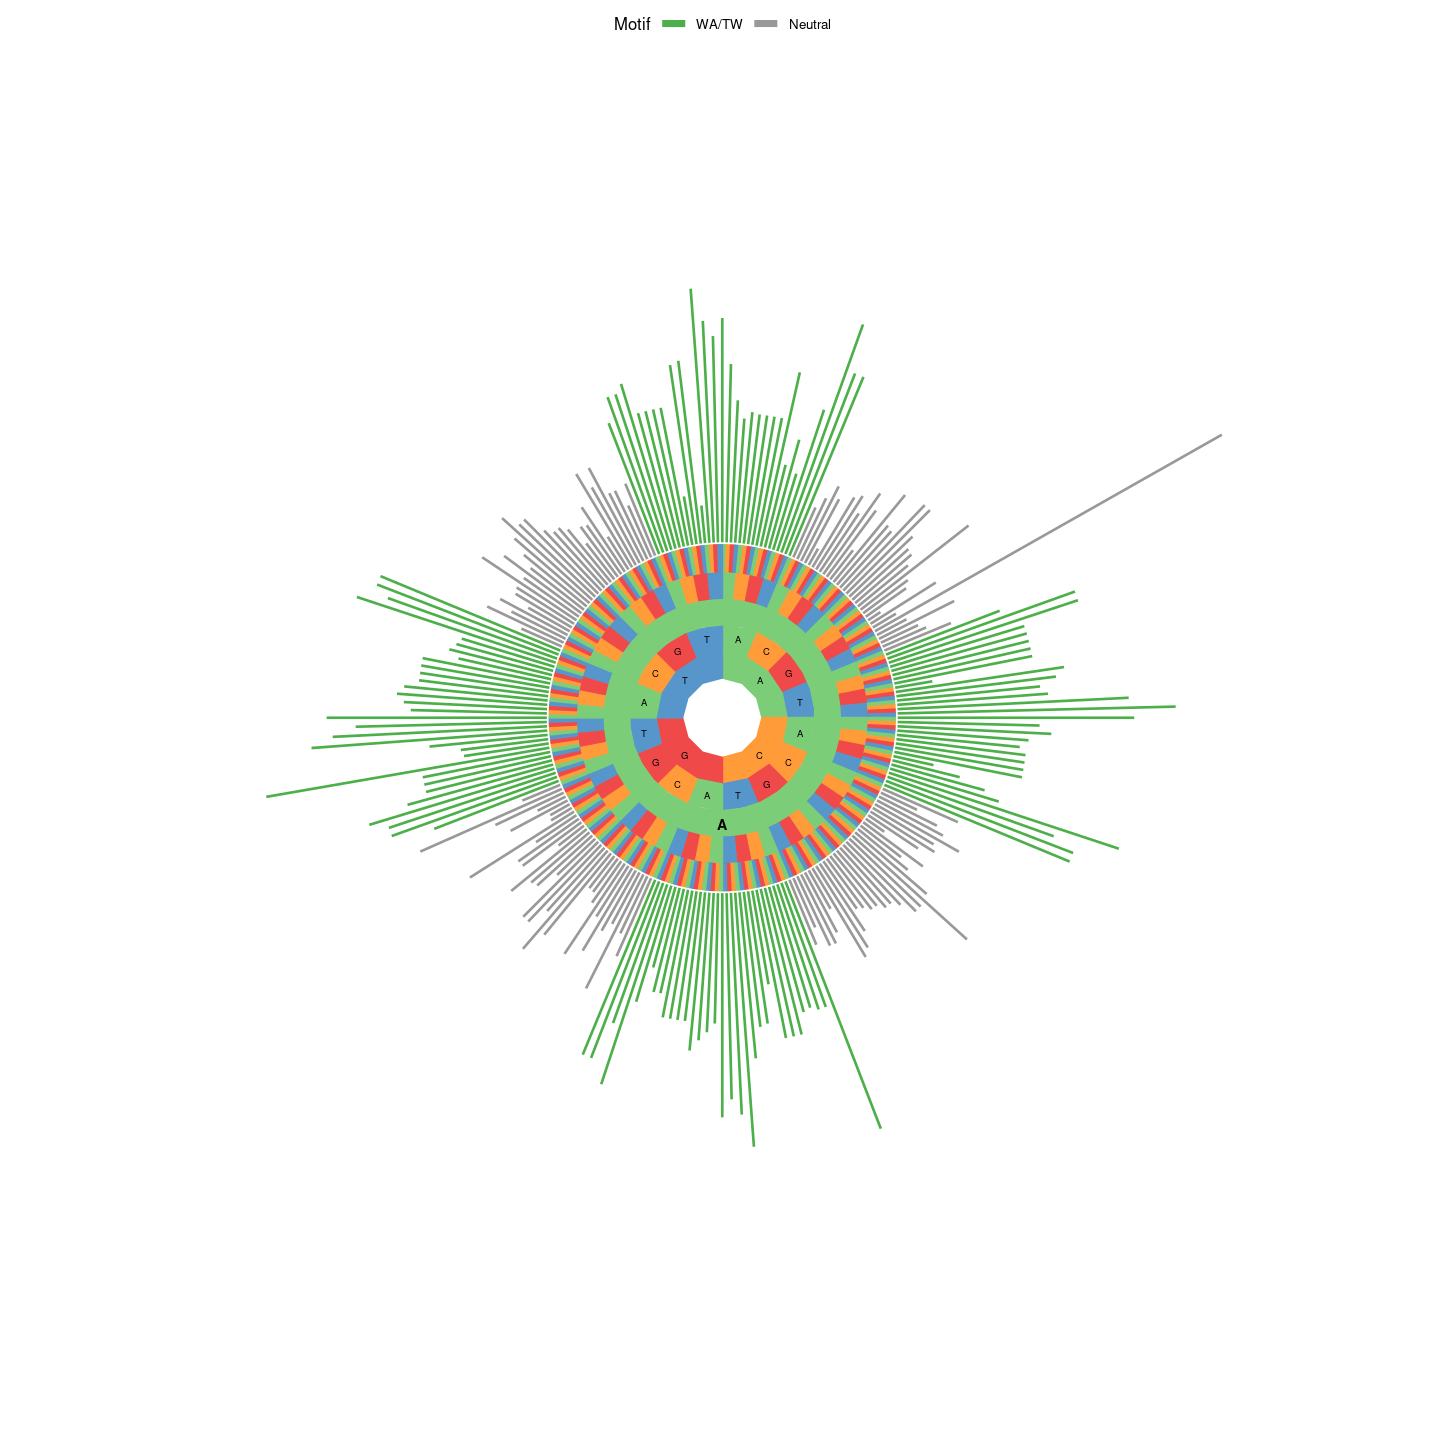

In [87]:
options(repr.plot.width=12, repr.plot.height=12)
plotMutability(model, nucleotides="A", style="hedgehog", size = 1)

# gene usage

In [189]:
# gene_usage_hc <- countGenes(HC_df, gene="v_call", groups="sample", mode="gene")
# gene_usage_sle <- countGenes(SLE_df, gene="v_call", groups="sample", mode="gene")
 gene_usage_all <- countGenes(filter_all_df, gene="v_call", groups="sample", mode="gene")

In [191]:
gene_usage_all

sample,gene,seq_count,seq_freq
<chr>,<chr>,<int>,<dbl>
LGY,IGHV3-23,320,0.11909192
HXX,IGHV4-34,230,0.08531157
HXX,IGHV4-59,222,0.08234421
XYY2,IGHV3-23,221,0.12878788
HXX,IGHV3-23,205,0.07603858
LGY,IGHV4-39,199,0.07406029
HXX,IGHV3-30,195,0.07232938
HXR,IGHV3-30,193,0.12491909
ZPP,IGHV3-23,186,0.13295211


In [192]:
ighv1 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV1") %>% left_join(meta,by = c('sample'='name'))

# Plot V gene usage in the IGHV1 family by sample
g1 <- ggplot(ighv1, aes(x=gene, y=seq_freq)) +
    theme_bw() +
    ggtitle("IGHV1 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV2
g2 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV2") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV2 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV3
g3 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV3") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV3 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV4
g4 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV4") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV4 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)


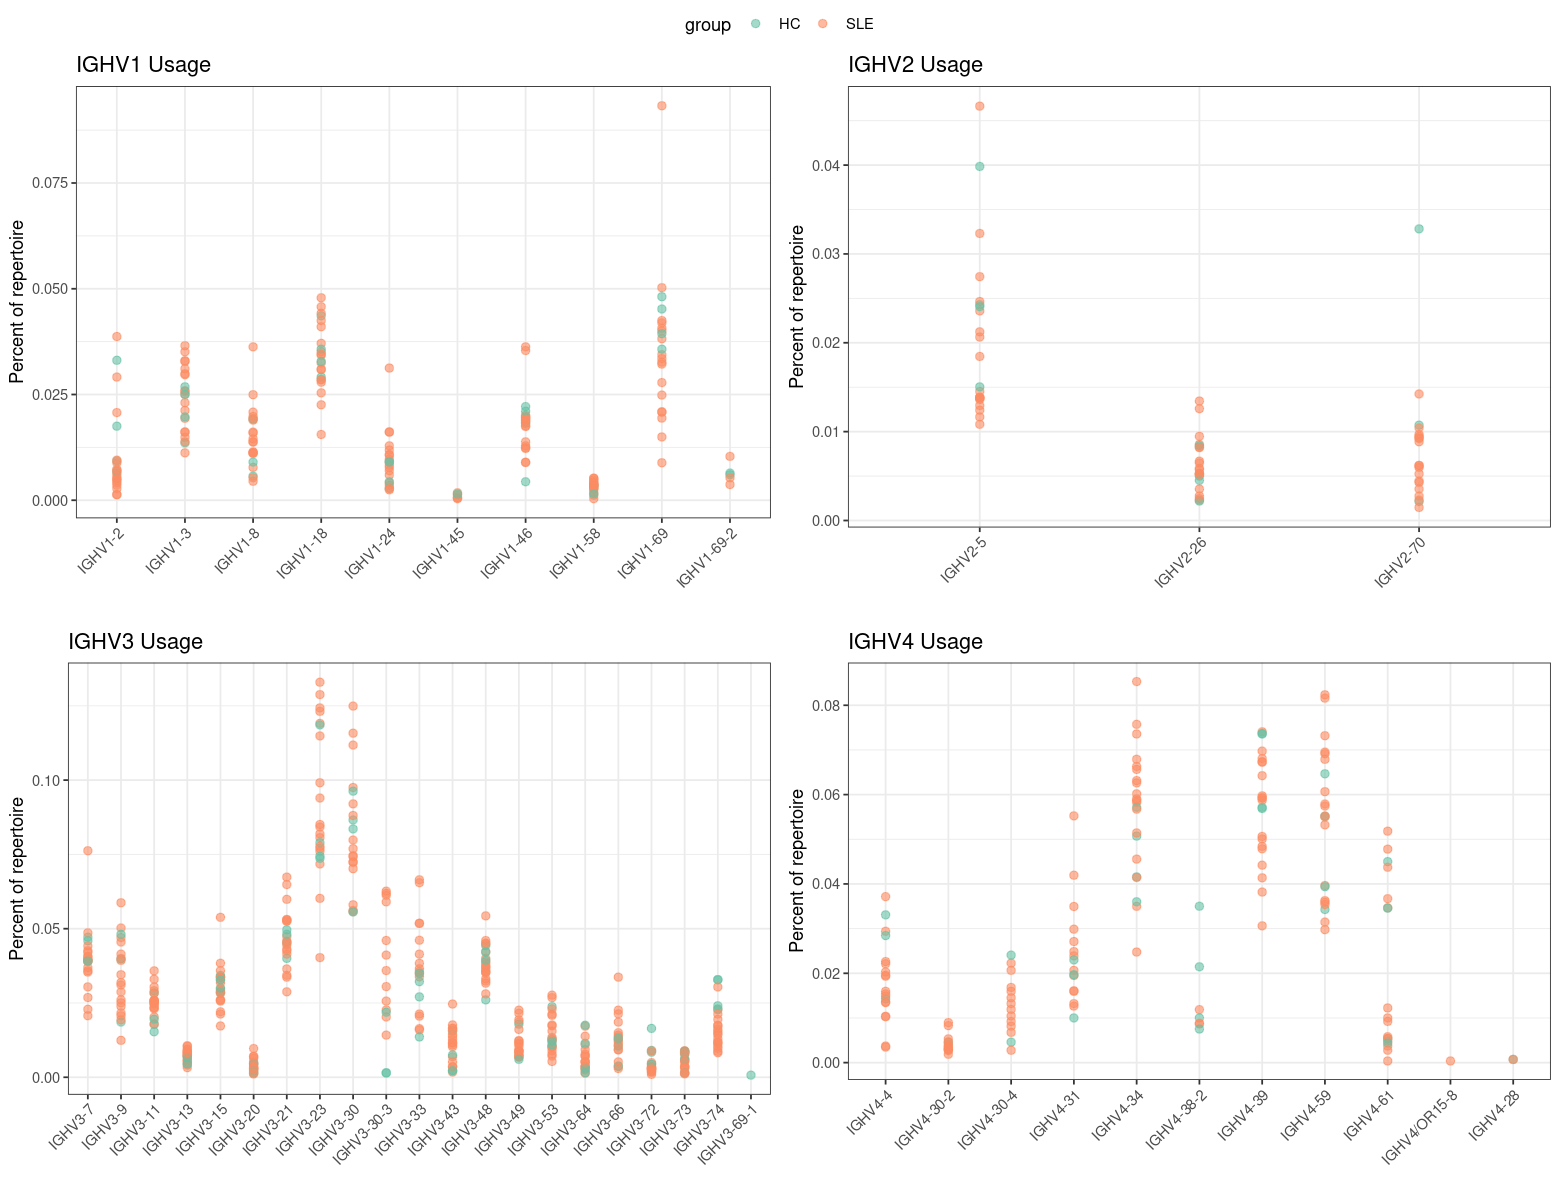

In [193]:
options(repr.plot.width=13, repr.plot.height=10)
ggarrange(g1,g2,g3,g4,common.legend = TRUE)

## use Fisher test

In [109]:
# all_df$v_call_10x %>% head()
# all_df$v_call %>% head()

[1] "IGHV3-74" "IGHV3-30" "IGHV1-8"  "IGHV3-53" "IGHV3-74" "IGHV3-53"

[1] "IGHV3-74*01"                          
[2] "IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03"
[3] "IGHV1-8*01"                           
[4] "IGHV3-53*01"                          
[5] "IGHV3-74*03"                          
[6] "IGHV3-53*01"

In [118]:
table(all_df$disease)


   HC   SLE 
 4913 32888 

In [209]:
fisher.result <- data.frame(matrix(NA, ncol =  3, nrow = 0))
for(i in unique(filter_all_df$v_call_10x)){
    this_gene_sle <- filter_all_df %>% filter(disease=='SLE',v_call_10x==i) %>% dim()
    this_gene_hc <- filter_all_df %>% filter(disease=='HC',v_call_10x==i) %>% dim()
    not_this_gene_sle <- table(filter_all_df$disease)[2] - this_gene_sle[1]
    not_this_gene_hc <- table(filter_all_df$disease)[1] - this_gene_hc[1]
    tmp_df <- data.frame("SLE" = c(this_gene_sle[1], not_this_gene_sle),"HC" = c(this_gene_hc[1], not_this_gene_hc), 
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result <- rbind(fisher.result, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}
fisher.result

X2.73553792170008e.08,X0.404520134343567,X0.644751910742688
<dbl>,<dbl>,<dbl>
2.735538e-08,0.404520134,0.6447519
8.891415e-14,1.813688935,3.0161402
1.431840e-01,0.923934982,1.8386736
2.590975e-01,0.639625323,1.1422759
9.224557e-01,0.817514343,1.2071930
2.658630e-02,0.735380901,0.9838599
1.450391e-02,1.035579851,1.4106669
8.192568e-01,0.855786637,1.2386936
3.240481e-04,1.138514953,1.5875505


In [200]:
colnames(fisher.result) <- c('p.value','down','up')
rownames(fisher.result) <- unique(filter_all_df$v_call_10x)
fisher.result$gene <- rownames(fisher.result)
fisher.result$mean <- 0.5*(fisher.result$down + fisher.result$up)


In [201]:
fisher.result %<>% filter(mean < 10)

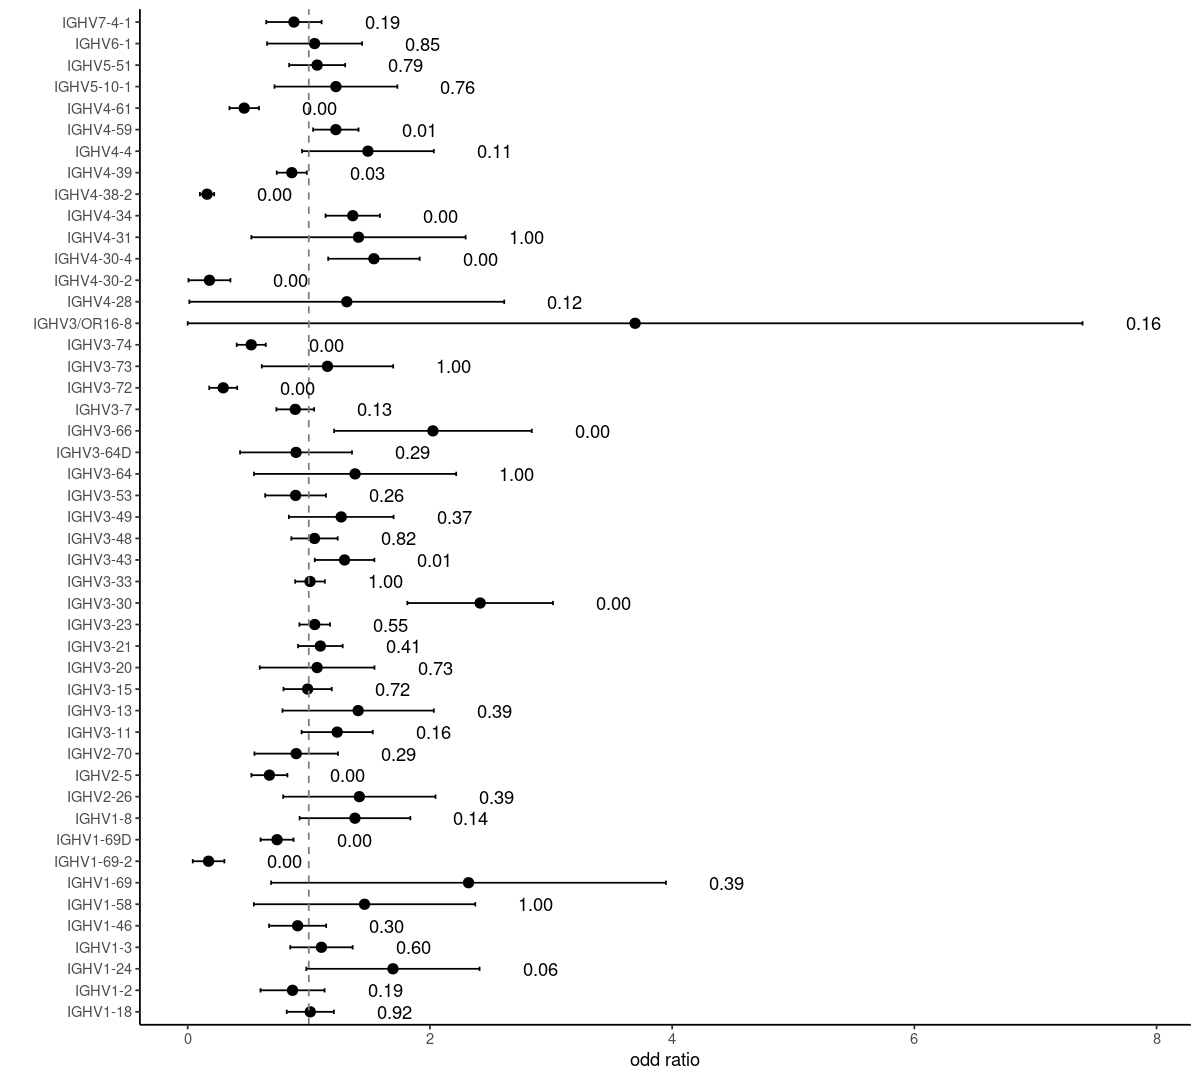

In [202]:
options(repr.plot.width =10, repr.plot.height=9)
ggplot(fisher.result, aes(x=gene, y=mean)) + 
  geom_point(size = 2.5)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=.2,
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), colour="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = sprintf("%.2f", p.value)), nudge_y = 0.5)+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA))  + theme_classic() 

## J gene

In [204]:
gene_usage_all_j <- countGenes(filter_all_df, gene="j_call", groups="sample", mode="gene")
options(repr.plot.width=13, repr.plot.height=10)
gene_usage_all_j$gene %>% table()

.
IGHJ1 IGHJ2 IGHJ3 IGHJ4 IGHJ5 IGHJ6 
   22    22    22    22    22    22 

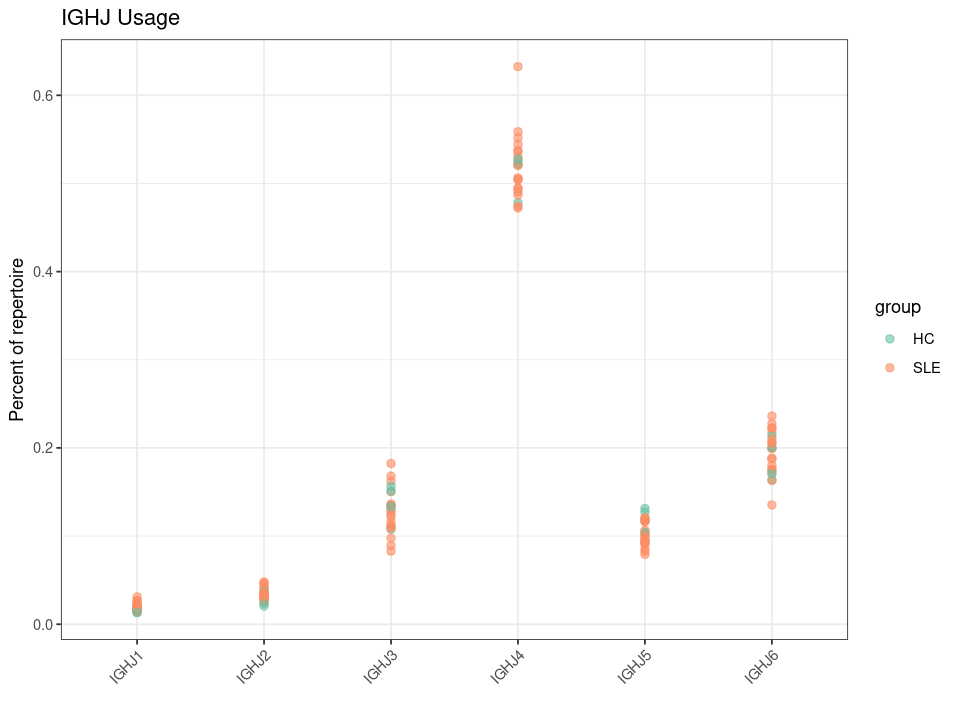

In [205]:
options(repr.plot.width =8, repr.plot.height=6)
gene_usage_all_j %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    # filter(getFamily(gene) == "IGHV1") %>% 
    left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHJ Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

In [213]:
fisher.result.j <- data.frame(matrix(NA, ncol =  3, nrow = 0))
colnames(fisher.result.j) <- c('p.value','down','up')
for(i in unique(filter_all_df$j_call_10x)){
    this_gene_sle <- filter_all_df %>% filter(disease=='SLE',j_call_10x==i) %>% dim()
    this_gene_hc <- filter_all_df %>% filter(disease=='HC',j_call_10x==i) %>% dim()
    not_this_gene_sle <- table(filter_all_df$disease)[2] - this_gene_sle[1]
    not_this_gene_hc <- table(filter_all_df$disease)[1] - this_gene_hc[1]
    tmp_df <- data.frame("SLE" = c(this_gene_sle[1], not_this_gene_sle),"HC" = c(this_gene_hc[1], not_this_gene_hc), 
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result.j <- rbind(fisher.result.j, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}

In [214]:
colnames(fisher.result.j) <- c('p.value','down','up')
rownames(fisher.result.j) <- unique(all_df$j_call_10x)
fisher.result.j$gene <- rownames(fisher.result.j)
fisher.result.j$mean <- 0.5*(fisher.result.j$down + fisher.result.j$up)

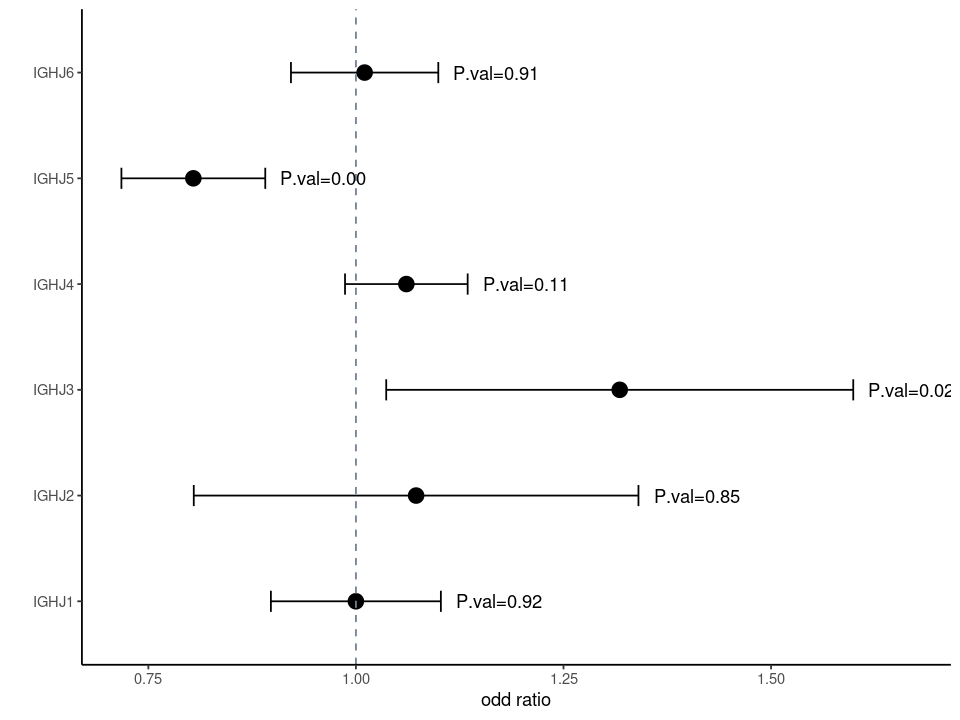

In [216]:
ggplot(fisher.result.j, aes(x=gene, y=mean)) + 
  geom_point(size = 4)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=.2,
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), colour="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = paste0('P.val=',sprintf("%.2f", p.value))), 
            nudge_y =0.07 )+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA)) + theme_classic()

# Physics and chemsitry  properties 

In [219]:
all_df %<>% filter(c_call != '')
db_props <- aminoAcidProperties(all_df, seq="junction", trim=TRUE, 
                                label="cdr3")

# The full set of properties are calculated by default
# dplyr::select(db_props[1:3, ], starts_with("cdr3"))

In [229]:
aa_g1 <-  ggboxplot(db_props, "c_call", "cdr3_aa_length", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g2 <-  ggboxplot(db_props, "c_call", "cdr3_aa_gravy", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g3 <-  ggboxplot(db_props, "c_call", "cdr3_aa_basic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g4 <-  ggboxplot(db_props, "c_call", "cdr3_aa_acidic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")

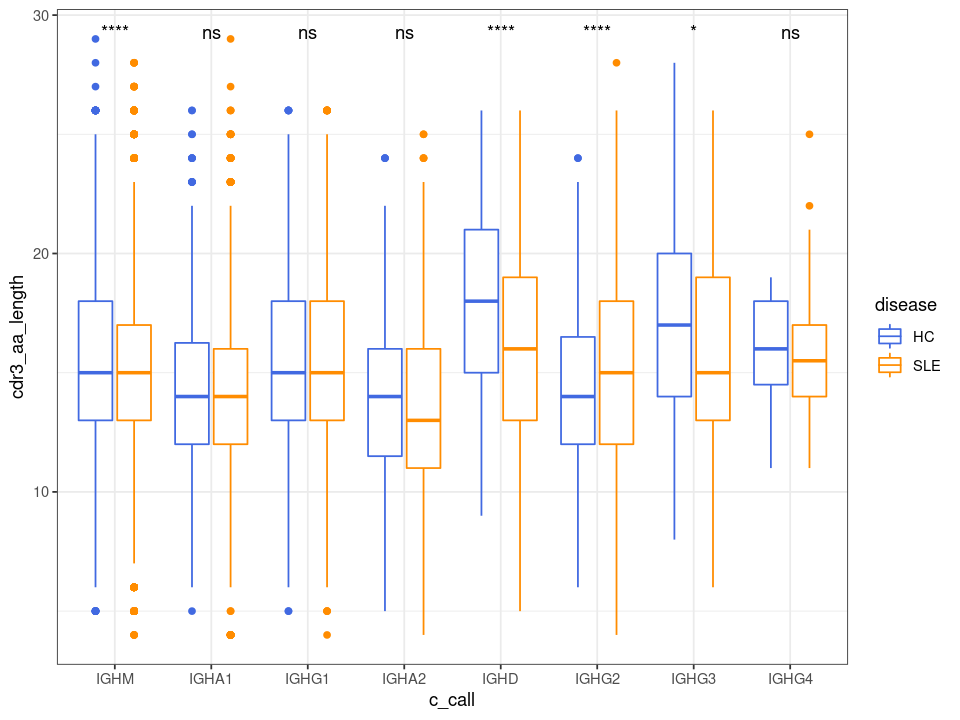

In [256]:
options(repr.plot.width =8, repr.plot.height=6)
aa_g1

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

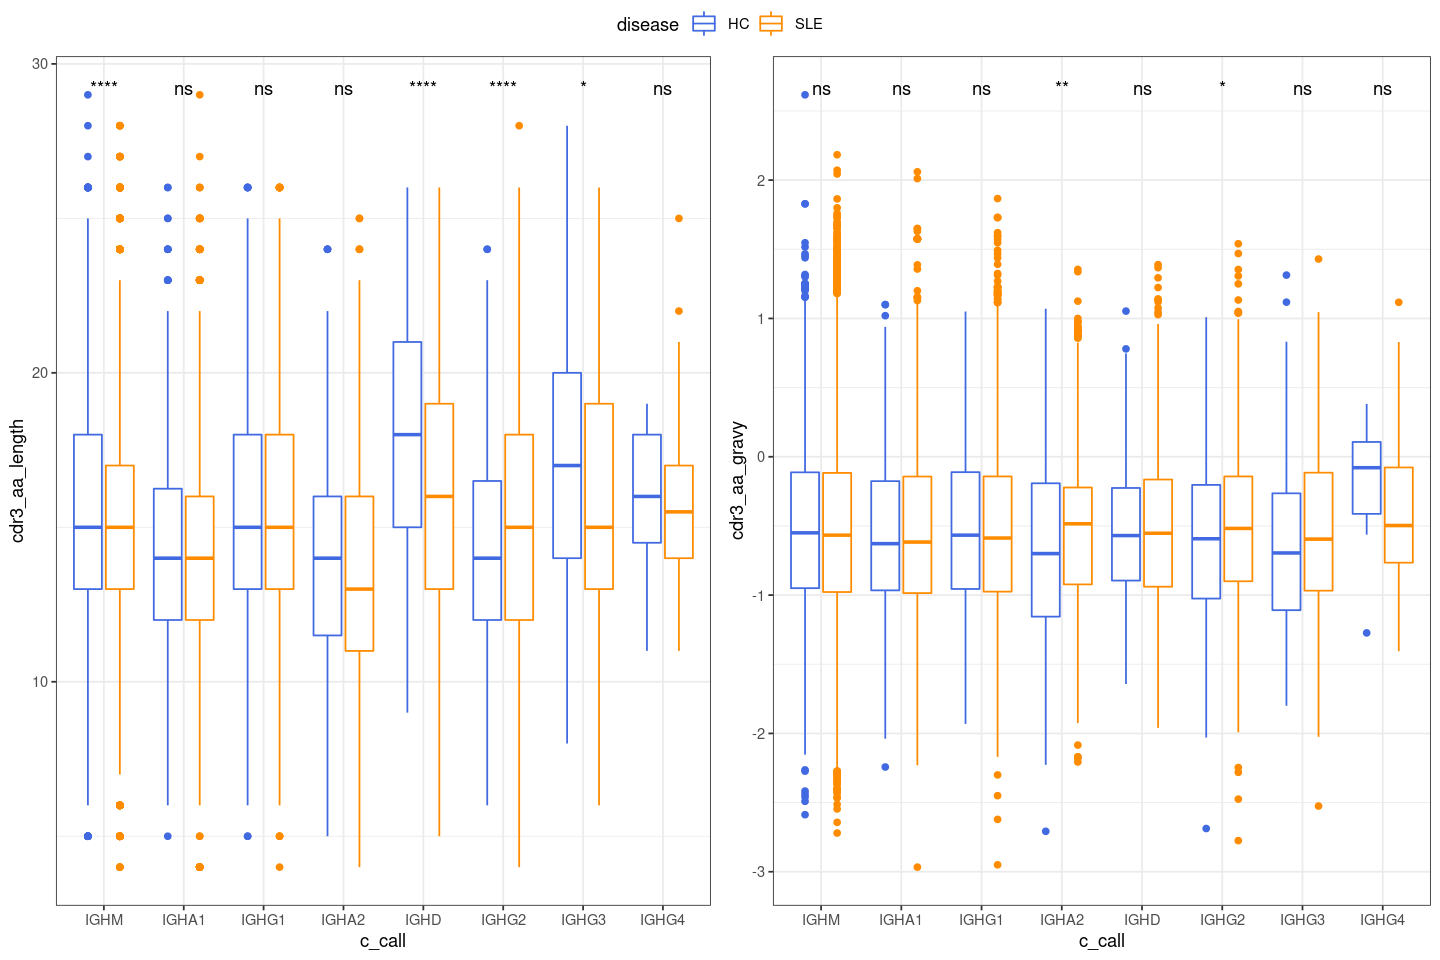

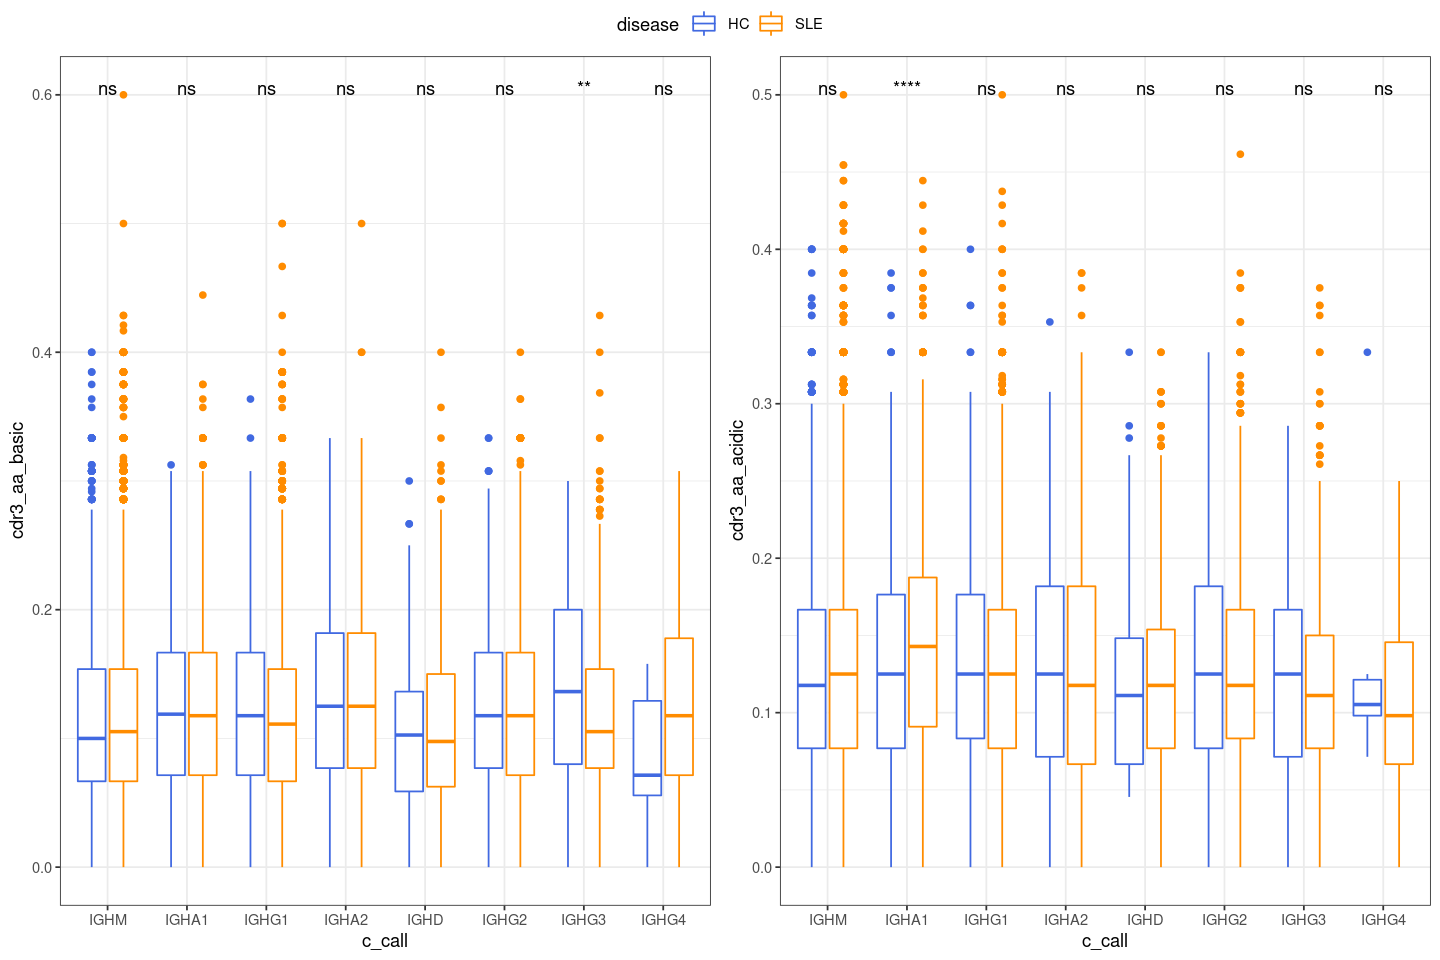

In [232]:
options(repr.plot.width =12, repr.plot.height=8)
# tmp_theme <- theme_bw() + theme(legend.position="bottom")
ggarrange(aa_g1, aa_g2, aa_g3, aa_g4, ncol=2,common.legend = TRUE)

# VH4-34 GENE


In [233]:
bcell_v4_34 <- filter_all_df %>% filter(v_call_10x == 'IGHV4-34') 
table(bcell_v4_34$disease) /table(filter_all_df$disease) 


        HC        SLE 
0.04546642 0.06004950 

In [230]:
# table(bcell_v4_34$disease,bcell_v4_34$subtype) %>% data.frame()
# table(filter_all_df$disease,filter_all_df$subtype)  %>% data.frame()
table(bcell_v4_34$disease,bcell_v4_34$subtype) 
table(filter_all_df$disease,filter_all_df$subtype)

     
      B.IFN-response B.mem B.mem.CD27- B.mem.CXCR3+ B.mem.IGHM+ B.naive
  HC               3    20          17           10          17      99
  SLE            113    43          72          117          38     542
     
      B.transition plasma plasma.IgA plasma.IgG plasmablast
  HC             6      1          0          1           0
  SLE          159     63         14         18          34

     
      B.IFN-response B.mem B.mem.CD27- B.mem.CXCR3+ B.mem.IGHM+ B.naive
  HC              60   625         172          478         419    1628
  SLE           1482  1407        1243         1752         831    8481
     
      B.transition plasma plasma.IgA plasma.IgG plasmablast
  HC           244     16        155          8          22
  SLE         2144   1104        557        441         758

In [235]:
tmp <- filter_all_df %>% filter(subtype=='B.mem.CD27-') 
dim(tmp)

[1] 1415   82

In [237]:
table(tmp$c_call)


      IGHA1 IGHA2  IGHD IGHG1 IGHG2 IGHG3 IGHG4  IGHM 
   23   105     5   102   456   119   137     3   465 

# Choose presure(can not work now)

In [233]:
clones <- collapseClones(all_df, cloneColumn="clone_id", 
                         sequenceColumn="sequence_alignment", 
                         germlineColumn="germline_alignment_d_mask", 
                         regionDefinition=IMGT_V, 
                         method="thresholdedFreq", minimumFrequency=0.6,
                         includeAmbiguous=FALSE, breakTiesStochastic=FALSE, 
                         nproc=24)

ERROR: Error in {: task 268 failed - "Expecting all sequences in the same clone with the same junction lenght."


In [245]:
all_df$clone_id %>% unique() %>% length()

[1] 33224